# PPCA in PyStan

In this notebook, we try to perform a PPCA in Pystan.

In [1]:
from mpl_toolkits.mplot3d import Axes3D
import pystan
import numpy as np
import seaborn as sns
sns.set()

Here, the model is defined in Stan. It is not yet the original model as defined by Pierson (2015) and it has only a signle $\sigma$, making it more of a ZI-PPCA, but it's a start.

In [22]:
zifa = """

data{
    int<lower=0> N; // number  of  datapoints
    int<lower=0> D; // number  of  dimensions  in  observed  dataset
    int<lower=0> M; // number  of  dimensions  in  latent  dataset
    matrix[N,D] y; // zero inflated observations
}

parameters{
    matrix[M,N] z;  // latent data
    matrix[D,M] W;  // factor loadings
    real<lower=0> sigma;   //  standard  deviations
    real<lower=0, upper=0.2> lambda; // zero-inflation
    matrix[N,D] x; // non-inflated observations
    vector[D] mu;   //  added means
}

model{
    
    for (d in 1:D){
        target+=normal_lpdf(W[d]|0.0, sigma);
        target+=normal_lpdf(mu[d]|8.0, 3.0) ;
    }
    
    target+=lognormal_lpdf(sigma|0.0, 1.0);
    
    for (n in 1:N){
        target+=normal_lpdf(z[:,n]|0.0,1.0);
        target+=normal_lpdf(x[n]|W*col(z,n)+mu, sigma);
    }
        
    for (n in 1:N){
        for (d in 1:D){
            if (y[n,d]==0){
                target+=bernoulli_lpmf(0|exp(-square(x[n,d])*lambda));
            } else {
                target+=bernoulli_lpmf(1|exp(-square(x[n,d])*lambda));
            }
        }
    }
}
"""
zifa = pystan.StanModel(model_code=zifa)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_cffff6ec4fecc24bd89a0b138ae870f0 NOW.


Note the log-probability in the 'model'-section of the code. We take $p(\mu)$, $p(W)$, $p(\sigma^2)$, $p(z)$ and $p(x|z)$ into account first. Then we take $p(h=1|x)$ or $p(h=0|x)$, depending on whether the datapoint is zero or non-zero. The reasoning behind this is given in the supplementary material of E. Pierson (2015). We end up with a complete likelihood of $$p(\mu)p(\sigma^2)p(W)\prod^N_{i=1}p(z_i)\Big(\prod_{j:y_{i,j}=0}p(x_{i,j}|z_i)p(h_{i,j}=1|x_{i,j})\prod_{j:y_{i,j}\neq}p(x_{i,j}|z_i)p(h_{i,j}=0|x_{i,j})\Big)$$

Note that our model takes the prior distributions of $\mu$, $\sigma^2$ and $W$ into account, while the original model does not. This is because these parameters were chosen manually or came from uniform distributions in the original paper, leaving them with flat priors.

We specify our parameters and generate some data.

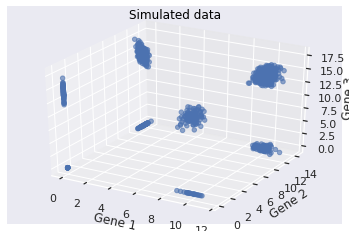

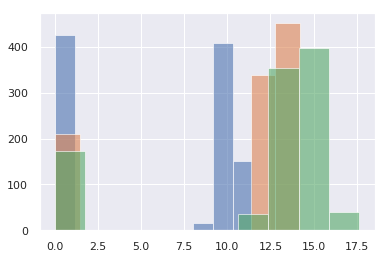

In [26]:
N=1000
M=2
D=3
z = np.random.normal(0,1, size=(M,N))
sigma = np.random.lognormal(0,1)
mu = np.random.normal(8,3,size=(D,1))
lamda = np.random.uniform(low=0,high=0.2)
W = np.random.normal(0,sigma,size=(D,M))
x = np.random.normal(np.matmul(W,z)+mu,sigma).T
h = np.random.binomial(n=1, p=1-np.exp(-(x**2)*lamda))
y = x*h

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(y[:,0],y[:,1],y[:,2], label='Observed data', alpha=0.6)
title = ax.set_title("Simulated data")
plt.setp(title, color='black') 
ax.set_xlabel('Gene 1')
ax.set_ylabel('Gene 2')
ax.set_zlabel('Gene 3')
plt.show()

plt.hist(y[:,0], alpha=0.6)
plt.hist(y[:,1], alpha=0.6)
plt.hist(y[:,2], alpha=0.6)
plt.show()

And then we can optimize our parameters and latent dataset.

In [27]:
ppca_dat = {'N': N, 'D':D, 'M':M, 'y':y}
fit = zifa.sampling(data=ppca_dat, chains=1, iter=2000)

best_ind = np.where(fit.extract()['lp__']==max(fit.extract()['lp__']))[0][0]

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [35]:
z_sim = fit.extract()['z'][best_ind]
sigma_sim = fit.extract()['sigma'][best_ind]
lambda_sim = fit.extract()['lambda'][best_ind]
W_sim = fit.extract()['W'][best_ind]
# x_sim_data = fit.extract()['x'][best_ind]
x_sim = np.random.normal(np.matmul(z_sim.T,W_sim.T),sigma_sim)    # or x can be recreated from z, W and sigma
h_sim = np.random.binomial(n=1, p=1-np.exp(-(x_sim_data**2)*lambda_sim))
y_sim = x_sim_data*h_sim

print('real sigma: ', sigma)
print('simulated sigma: ', sigma_sim)
print()
print('real lambda: ', lamda)
print('simulated lambda: ', lambda_sim)
print()
print('real z: ', z)
print('simulated z: ', z_sim)
print()
print('real WW^T:\n', np.matmul(W,W.T))
print('simulated WW^T:\n', np.matmul(W_sim,W_sim.T))
print()

real sigma:  0.32498217924424366
simulated sigma:  5.587314537159232

real lambda:  0.009184791858779406
simulated lambda:  0.007150744657687969

real z:  [[-1.29318907 -0.98085507  0.50914351 ...  1.11250565  1.67809629
   0.10089191]
 [ 0.43759115  0.33783859 -0.19699198 ... -0.35308633 -0.65744888
  -0.80835618]]
simulated z:  [[ 0.01410293 -1.37726585  0.7531963  ... -0.25880038  1.14178535
   0.23158136]
 [-0.25879426 -0.58726578 -0.69217636 ... -0.17091798  1.39701343
   0.82453853]]

real WW^T:
 [[ 0.12337706 -0.05840618  0.26654493]
 [-0.05840618  0.09919612 -0.29482314]
 [ 0.26654493 -0.29482314  0.97334896]]
simulated WW^T:
 [[108.86057783   8.82306977  10.45409979]
 [  8.82306977  13.77637225   5.23268671]
 [ 10.45409979   5.23268671   2.47634577]]



The result is plotted below. The result is very strange.

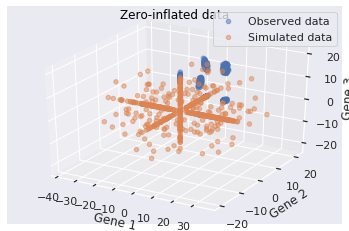

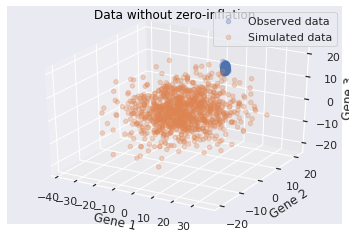

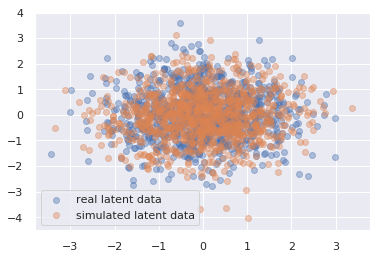

In [32]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(y[:,0],y[:,1],y[:,2], label='Observed data', alpha=0.5)
ax.scatter(y_sim[:,0],y_sim[:,1],y_sim[:,2], label='Simulated data', alpha=0.5)
title = ax.set_title("Zero-inflated data")
plt.setp(title, color='black') 
ax.set_xlabel('Gene 1')
ax.set_ylabel('Gene 2')
ax.set_zlabel('Gene 3')
plt.legend()
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x[:,0],x[:,1],x[:,2], label='Observed data', alpha=0.3)
ax.scatter(x_sim_data[:,0],x_sim_data[:,1],x_sim_data[:,2], label='Simulated data', alpha=0.3)
title = ax.set_title("Data without zero-inflation")
plt.setp(title, color='black') 
ax.set_xlabel('Gene 1')
ax.set_ylabel('Gene 2')
ax.set_zlabel('Gene 3')
plt.legend()
plt.show()


plt.scatter(z[0,:], z[1,:], label='real latent data', alpha=0.4)
plt.scatter(z_sim[0,:], z_sim[1,:], label='simulated latent data', alpha=0.4)
plt.legend()
plt.show()


## ZIFA by parts
A next attempt will be to create a seperate latent variable model and a zero-inflated model, so that we can hopefully add then together later.

### Latent variable

In [65]:
latent_mu = """

data{
    int<lower=0> N;// number  of  datapoints
    int<lower=0> D;// number  of  dimensions  in  observed  dataset
    int<lower=0> M;// number  of  dimensions  in  latent  dataset
    vector[D] x[N];//  observations
}


parameters{
    matrix[M,N] z;  // latent data
    matrix[D,M] W;  // factor loadings
    real<lower=0> sigma;   //  standard  deviations
    vector[D] mu;   //  added means
}

model{
    //  priors
    to_vector(z) ~ normal(0.0,1.0);
    for (d in 1:D){
        W[d] ~ normal(0.0,sigma);
        mu[d]~normal(0.0, 5.0) ;
        }
    sigma~lognormal(0.0, 1.0) ;
    
    
    //  likelihood
    for (n in 1:N)
        x[n] ~ normal(W*col(z,n)+mu, sigma);
}
"""
ppca = pystan.StanModel(model_code=latent_mu)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_be233f9d9d0bebbf3ffe0592c0372481 NOW.


In [56]:
N=1000
M=2
D=3
z = np.random.normal(0,1, size=(N,M))
sigma = np.random.lognormal(0,1)
mu = np.random.normal(0,5,size=D)
W = np.random.normal(0,sigma,size=(M,D))
x = np.random.normal(np.matmul(z,W)+mu,sigma)
    
ppca_dat = {'N': N, 'D':D, 'M':M, 'x':x}

In [57]:
op = ppca.optimizing(data=ppca_dat)

z_sim = op['z'].T
sigma_sim = op['sigma']
W_sim = op['W'].T
mu_sim = op['mu'].T
x_sim = np.random.normal(np.matmul(z_sim,W_sim)+mu,sigma_sim)

print('real mu: ', mu)
print('simulated mu: ', mu_sim)
print()
print('real sigma: ', sigma)
print('simulated sigma: ', sigma_sim)
print()
print('real z: ', z)
print('simulated z: ', z_sim)
print()
print('real W: ', W)
print('simulated W: ', W_sim)
print()

real mu:  [0.03250107 3.49938245 6.11210758]
simulated mu:  [0.03224085 3.47193728 6.07978394]

real sigma:  0.7937426045310461
simulated sigma:  0.4782384994253427

real z:  [[ 0.2848906   0.63924748]
 [ 0.36421231  1.69141531]
 [ 1.33094396  1.06255413]
 ...
 [-0.40776494 -1.20539517]
 [ 1.27397965 -0.62457198]
 [-0.38150225 -0.26137449]]
simulated z:  [[ 0.32303224 -0.23019606]
 [ 0.16972621 -0.50069227]
 [ 0.56955388 -0.57451808]
 ...
 [-0.30316614  0.29476605]
 [ 0.18743356  0.29397447]
 [-0.06590484 -0.00786075]]

real W:  [[ 0.33485412  1.14840772 -0.44357654]
 [-0.29798209  1.29141625  0.55956644]]
simulated W:  [[ 1.50303096  4.01374469 -2.1141961 ]
 [ 1.73221969 -3.46293759 -2.73474741]]



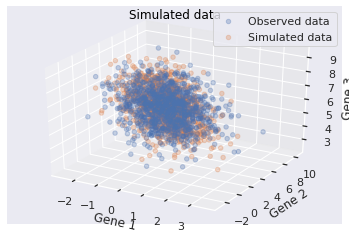

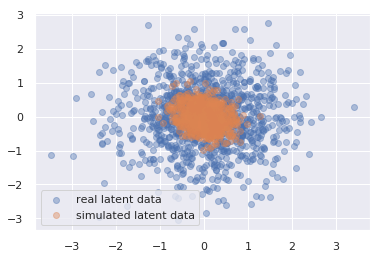

In [58]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x[:,0],x[:,1],x[:,2], label='Observed data', alpha=0.3)
ax.scatter(x_sim[:,0],x_sim[:,1],x_sim[:,2], label='Simulated data', alpha=0.3)
title = ax.set_title("Simulated data")
plt.setp(title, color='black') 
ax.set_xlabel('Gene 1')
ax.set_ylabel('Gene 2')
ax.set_zlabel('Gene 3')
plt.legend()
plt.show()

plt.scatter(z[:,0], z[:,1], label='real latent data', alpha=0.4)
plt.scatter(z_sim[:,0], z_sim[:,1], label='simulated latent data', alpha=0.4)
plt.legend()
plt.show()

### Zero-inflated model

In [66]:
bernoulli_model = """

data{
    int<lower=0> N;// number  of  datapoints
    int<lower=0> D;// number  of  dimensions  in  observed  dataset
    int<lower=0> M;// number  of  dimensions  in  latent  dataset
    vector[D] x[N];//  observations
    vector[D] y[N];//  zero-inflated observations
}


parameters{
    real<lower=0, upper=0.2> lambda;   //  inflation
}

model{
    
    for (n in 1:N){
        for (d in 1:D){
            if (y[n,d]==0){
                target+=bernoulli_lpmf(0|exp(-square(x[n,d])*lambda));
            } else {
                target+=bernoulli_lpmf(1|exp(-square(x[n,d])*lambda));
            }
        }
    }
}
"""
dropout_model = pystan.StanModel(model_code=bernoulli_model)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_e6ce99a6f45f58efc1cb7391440e232b NOW.


In [60]:
N=1000
D=3
lamda = np.random.uniform(0,0.2)
W = np.random.normal(0,sigma,size=(M,D))
x = np.random.normal(np.matmul(z,W)+mu,sigma)
h = np.random.binomial(n=1, p=np.exp(-(x**2)*lamda))
y = x*h
    
ppca_dat = {'N': N, 'D':D, 'M':M, 'x':x, 'y':y}

In [61]:
op = ppca.optimizing(data=ppca_dat)

print('real lambda: ', lamda)
print('simulated lambda: ', op['lambda'])

real lambda:  0.06894163045230231
simulated lambda:  0.06445434321112678


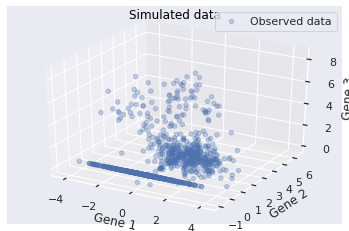

In [62]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(y[:,0],y[:,1],y[:,2], label='Observed data', alpha=0.3)
title = ax.set_title("Simulated data")
plt.setp(title, color='black') 
ax.set_xlabel('Gene 1')
ax.set_ylabel('Gene 2')
ax.set_zlabel('Gene 3')
plt.legend()
plt.show()

### Adding the two together (Everything beneath this point is not functional)

In [67]:
N=1000
M=2
D=3
z = np.random.normal(0,1, size=(N,M))
sigma = np.random.lognormal(0,1)
mu = np.random.normal(8,3,size=D)
lamda = np.random.uniform(low=0,high=0.2)
W = np.random.normal(0,sigma,size=(M,D))
x = np.random.normal(np.matmul(z,W)+mu,sigma)
h = np.random.binomial(n=1, p=1-np.exp(-(x**2)*lamda))
y = x*h

In [69]:
y_nonzero = y[sum((y!=0).T)==D]
print(len(y_nonzero), ' entries found without dropout.')

ppca_dat = {'N': len(y_nonzero), 'D':D, 'M':M, 'x':y_nonzero}

op = ppca.optimizing(data=ppca_dat)

z_sim = op['z'].T
sigma_sim = op['sigma']
W_sim = op['W'].T
mu_sim = op['mu'].T
x_sim = np.random.normal(np.matmul(z_sim,W_sim)+mu,sigma_sim)

print('real mu: ', mu)
print('simulated mu: ', mu_sim)
print()
print('real sigma: ', sigma)
print('simulated sigma: ', sigma_sim)
print()
print('real z: ', z)
print('simulated z: ', z_sim)
print()
print('real W: ', W)
print('simulated W: ', W_sim)
print()

577  entries found without dropout.
real mu:  [8.36516524 7.75858035 6.93510637]
simulated mu:  [8.56352021 7.72661498 7.741414  ]

real sigma:  2.5980772642584933
simulated sigma:  1.409351271182789

real z:  [[ 1.10446777 -2.14076429]
 [-1.76964785  0.34339223]
 [ 1.0207143  -0.28437118]
 ...
 [-0.49064098  0.8980428 ]
 [-0.18310696 -0.70641841]
 [-1.98168258  1.3561434 ]]
simulated z:  [[ 1.15063073  0.63780138]
 [-0.28252877  0.01747932]
 [-0.21739951  0.02550978]
 ...
 [-0.10677874 -0.13526507]
 [ 0.03796956  0.21374221]
 [-1.12607637 -0.45801439]]

real W:  [[-0.64694913  1.98763162 -3.44857526]
 [-0.25809305 -5.82840307  4.14118929]]
simulated W:  [[ -0.90084183   8.93850388 -12.81445958]
 [  0.9054422   11.33624113   2.11444953]]



In [ ]:

ppca_dat = {'N': N, 'D':D, 'M':M, 'x':x, 'y':y}



In [104]:
ZIFA = """

data{
    int<lower=0> N;// number  of  datapoints
    int<lower=0> D;// number  of  dimensions  in  observed  dataset
    int<lower=0> M;// number  of  dimensions  in  latent  dataset
    vector[D] y[N];//  zero-inflated observations
}


parameters{
    real<lower=0, upper=0.2> lambda;   //  inflation
    real<lower=0> sigma;   //  standard  deviations
    vector[D] mu;   //  added means
    vector[D] x[N];//  observations
}

model{
    
    target+=normal_lpdf(mu|8.0,3.0);
    target+=lognormal_lpdf(sigma|0.0, 1.0) ;
    
    for (n in 1:N){
        target+=normal_lpdf(x[n]|mu, sigma);
        for (d in 1:D){
            if (y[n,d]==0){
                target+=bernoulli_lpmf(0|exp(-square(x[n,d])*lambda));
            } else {
                target+=bernoulli_lpmf(1|exp(-square(x[n,d])*lambda));
            }
        }
    }
}
"""
ZIFA = pystan.StanModel(model_code=ZIFA)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_c1e10e948876f0f062be297fa6cca8f1 NOW.


In [290]:
N=10000
D=3
z = np.random.normal(0,1, size=(N,M))
lamda = np.random.uniform(0,0.2)
mu = np.random.normal(8,3, size=D)
sigma = np.random.lognormal(0,1)
x = np.random.normal(mu,sigma,(N,D))
h = np.random.binomial(n=1, p=1-np.exp(-(x**2)*lamda))
y = x*h

np.shape(y[sum((y!=0).T)==D])

(6452, 3)

In [292]:
y_nonzero = y[sum((y!=0).T)==D]

ppca_dat_nonzero = {'N': len(y_nonzero), 'D':D, 'M':M, 'x':y_nonzero}

op1 = ppca.optimizing(data=ppca_dat_nonzero)

print('non-zero datapoints: ',len(y_nonzero))
print('real sigma: ', sigma)
print('simulated sigma: ', op1['sigma'])
print('real mu: ', mu)
print('simulated mu: ', op1['mu'])
print('real W: ', W)
print('simulated W: ', op1['W'])


non-zero datapoints:  6452
real sigma:  0.25732325162223324
simulated sigma:  0.14663881390007716
real mu:  [13.16879615  8.90135883  6.39606621]
simulated mu:  [13.18010518  8.90772552  6.39828613]
real W:  [[ 9.20953327 -1.34449514  2.54649452]
 [ 2.39196371  4.82488954  0.06069166]]
simulated W:  [[ 0.95304816  1.45683828]
 [ 0.53864527 -0.12758331]
 [-1.3263773   0.95535122]]


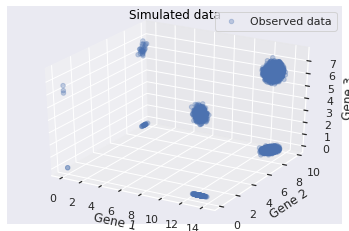

In [291]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(y[:,0],y[:,1],y[:,2], label='Observed data', alpha=0.3)
title = ax.set_title("Simulated data")
plt.setp(title, color='black') 
ax.set_xlabel('Gene 1')
ax.set_ylabel('Gene 2')
ax.set_zlabel('Gene 3')
plt.legend()
plt.show()

In [108]:
latent_mu = """

data{
    int<lower=0> N;// number  of  datapoints
    int<lower=0> D;// number  of  dimensions  in  observed  dataset
    int<lower=0> M;// number  of  dimensions  in  latent  dataset
    vector[D] x[N];//  observations
}


parameters{
    matrix[M,N] z;  // latent data
    matrix[D,M] W;  // factor loadings
    real<lower=0> sigma;   //  standard  deviations
    vector[D] mu;   //  added means
}

model{
    //  priors
    to_vector(z) ~ normal(0.0,1.0);
    for (d in 1:D){
        W[d] ~ normal(0.0,sigma);
        mu[d]~normal(0.0, 5.0) ;
        }
    sigma~lognormal(0.0, 1.0) ;
    
    
    //  likelihood
    for (n in 1:N)
        x[n] ~ normal(W*col(z,n)+mu, sigma);
}
"""
ppca = pystan.StanModel(model_code=latent_mu)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_be233f9d9d0bebbf3ffe0592c0372481 NOW.


In [ ]:
ZIFA = """

data{
    int<lower=0> N;// number  of  datapoints
    int<lower=0> D;// number  of  dimensions  in  observed  dataset
    int<lower=0> M;// number  of  dimensions  in  latent  dataset
    vector[D] x[N];//  observations
    vector[D] y[N];//  zero-inflated observations
}


parameters{
    real<lower=0, upper=0.2> lambda;   //  inflation
    real<lower=0> sigma;   //  standard  deviations
    vector[D] mu;   //  added means
}

model{
    
    target+=normal_lpdf(mu|8.0,3.0);
    target+=lognormal_lpdf(sigma|0.0, 1.0) ;
    
    //target+=normal_lpdf(x|mu,sigma);
    
    //x~normal(mu, sigma);
    for (n in 1:N){
        for (d in 1:D){
            if (y[n,d]==0){
                target+=bernoulli_lpmf(0|exp(-square(x[n,d])*lambda));
            } else {
                target+=bernoulli_lpmf(1|exp(-square(x[n,d])*lambda));
                target+=normal_lpdf(y[n]|mu[d], sigma);
            }
        }
    }
}
"""
ZIFA = pystan.StanModel(model_code=ZIFA)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_1b3921733bbd3b0553ab2170dcc4f0e9 NOW.
